In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
import re

# CSV 파일에서 데이터 로드
file_path = '20240703_correlation_copy.csv'
df = pd.read_csv(file_path)

# 열 목록
columns = df.columns

# R^2 값을 저장할 행렬 초기화
r2_matrix = pd.DataFrame(index=columns, columns=columns)

# 각 열을 종속 변수로 지정
for dependent_var in columns:
    independent_vars = df.columns.difference([dependent_var])
    
    for var in independent_vars:
        # 결측치 제거
        valid_data = df[[var, dependent_var]].dropna()
        
        X = valid_data[[var]]
        y = valid_data[dependent_var]
        
        if len(valid_data) > 0:  # 유효한 데이터가 있는지 확인
            # 다항식 특징 변환기 생성 (차수 2로 설정)
            poly = PolynomialFeatures(degree=3)
            X_poly = poly.fit_transform(X)
            
            # 모델 훈련
            model = LinearRegression()
            model.fit(X_poly, y)
            
            # 예측
            y_pred = model.predict(X_poly)
            
            # R^2 계산
            r2 = r2_score(y, y_pred)
            r2_matrix.loc[var, dependent_var] = r2

        else:
            r2_matrix.loc[var, dependent_var] = np.nan  # 유효한 데이터가 없으면 NaN으로 설정

# r2_matrix를 CSV 파일로 저장
output_file_path = '20240715_cubic_r2.csv'  # 저장할 파일 경로
r2_matrix.to_csv(output_file_path)

# R^2 값이 0.9 이상인 모델 찾기
high_r2_models = r2_matrix[r2_matrix >= 0.90].stack().reset_index()
high_r2_models.columns = ['Independent_Var', 'Dependent_Var', 'R2']


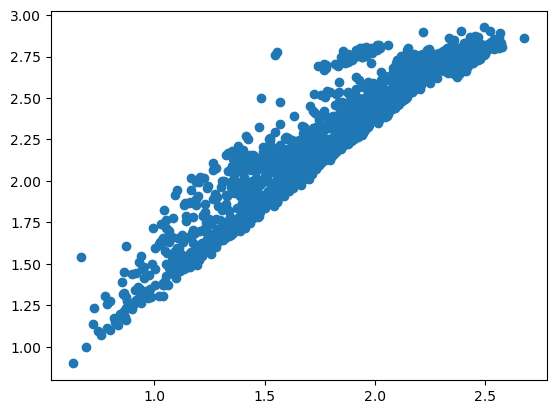

In [3]:
# 첫 번째 모델에 대해 CSV 파일과 그래프 저장
row = high_r2_models.iloc[5]
independent_var = row['Independent_Var']
dependent_var = row['Dependent_Var']
r2 = row['R2']

# 결측치 제거
valid_data = df[[independent_var, dependent_var]].dropna()

X = valid_data[[independent_var]]
y = valid_data[dependent_var]

# 다항식 특징 변환기 생성 (차수 2로 설정)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

plt.scatter(X, y)

In [6]:
# 모델 학습 및 예측
model = LinearRegression()
model.fit(X_poly, y)

# 계수와 절편 출력
print("다항식 계수:", model.coef_)
print("절편:", model.intercept_)

X_fit = np.arange(0.7, 2.5, 0.01)[:, np.newaxis]
y_pred = model.predict(poly.fit_transform(X_fit))

# 그래프 생성
plt.figure()
plt.plot(X_fit, y_pred, 'b-', lw=2)
plt.scatter(X, y, color='red', alpha=0.5)
plt.xlabel(f'{independent_var}')
plt.ylabel(f'{dependent_var}')
plt.title(f'Cubic Correlation: {independent_var}__{dependent_var}')

# 다항식 계수를 이용하여 수식 생성
intercept = model.intercept_
coef = model.coef_

# LaTeX 수식 생성
equation = f'$y = {intercept:.2f} + {coef[1]:.2f}x + {coef[2]:.2f}x^2 {coef[3]:.2f}x^3$'

# 수식을 그래프에 추가
plt.text(x=0.05, y=0.90, s=equation, fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)

# R^2, MAE 값 그래프에 추가
plt.text(x=0.05, y=0.95, s=f'$R^2 = {r2:.4f}$', fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)

# 파일 이름에서 유효하지 않은 문자 제거
def sanitize_filename(filename):
    return re.sub(r'[\\/*?:"<>|]', "_", filename)

# 그래프 이미지 파일로 저장
img_filename = sanitize_filename(f'Cubic Correlation between {independent_var}__{dependent_var}.png')
plt.savefig(img_filename)
plt.close()


다항식 계수: [ 0.          0.4490435   0.48662068 -0.12804229]
절편: 0.6503660595178253


In [7]:
# 모델 예측
y_pred = model.predict(X_poly)

# Convert it to kcal/mole
mae = MAE(y, y_pred)*23.06
print(f'MAE: {mae} (kcal/mol)')

# 실제 값과 예측치 저장
result_df = pd.DataFrame({
    'Real': y,
    'Predict': y_pred
})

csv_filename = sanitize_filename(f'{independent_var}__{dependent_var}.csv')
result_df.to_csv(csv_filename, index=False)

# 그래프 생성
plt.figure()
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', lw=2)
plt.scatter(y, y_pred, color='red', alpha=0.5)
plt.xlabel(f'Actual values of {dependent_var}')
plt.ylabel(f'Predicted values of {dependent_var}')
plt.title(f'Model: {independent_var}__{dependent_var}')

# R^2 값 그래프에 추가
plt.text(x=0.05, y=0.95, s=f'$R^2 = {r2:.4f}$', fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(x=0.05, y=0.90, s=f'MAE = {mae:.4f} (kcal/mol)', fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)

# 그래프 이미지 파일로 저장
img_filename = sanitize_filename(f'{independent_var}__{dependent_var}.png')
plt.savefig(img_filename)
plt.close()

MAE: 2.1796061955708774 (kcal/mol)
